## Model Development

#### import data

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
df = pd.read_csv('data/df_fs.csv', sep=",", index_col=0)

In [10]:
df.head()

,date,Open,Low,Close,Volume,30_day_MA,60_day_MA,90_day_MA,RSI,MACD,MACD_Histogram,Price_Change_Pct,Article Length,article_sentiment,Price_Change_Category,smoothed_sentiment
0,2016-07-20,56.840000,55.529999,55.910000,89893300.0,51.945666,52.309333,50.519333,71.721804,0.558581,0.518174,5.311734,1394.0,4.0,positive,4.0
1,2016-07-25,56.740002,56.259998,56.730000,25610600.0,52.099999,52.403333,50.659777,74.606512,0.835840,0.636346,0.282835,623.0,4.0,positive,4.0
2,2016-08-01,56.750000,56.139999,56.580002,26003400.0,52.249333,52.476499,50.799666,91.388238,1.031574,0.665664,-0.176426,269.0,4.0,negative,4.0
3,2016-08-03,57.110001,56.490002,56.970001,22075600.0,52.411666,52.548499,50.945111,91.799325,1.204282,0.670698,0.689288,904.0,4.0,positive,4.0
4,2016-08-05,58.209999,57.450001,57.959999,29335200.0,52.606999,52.658499,51.118444,92.480413,1.404845,0.697009,0.993204,679.0,1.0,positive,3.4


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4983 entries, 0 to 4982
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   4983 non-null   object 
 1   Open                   4983 non-null   float64
 2   Low                    4983 non-null   float64
 3   Close                  4983 non-null   float64
 4   Volume                 4983 non-null   float64
 5   30_day_MA              4983 non-null   float64
 6   60_day_MA              4983 non-null   float64
 7   90_day_MA              4983 non-null   float64
 8   RSI                    4983 non-null   float64
 9   MACD                   4983 non-null   float64
 10  MACD_Histogram         4983 non-null   float64
 11  Price_Change_Pct       4983 non-null   float64
 12  Article Length         4983 non-null   float64
 13  article_sentiment      4983 non-null   float64
 14  Price_Change_Category  4983 non-null   object 
 15  smoothed_

In [12]:
import pandas as pd
import numpy as np
from scipy import stats

# Example data
event_date = '2024-04-20'
window_days = 5
stock_prices = pd.DataFrame({'Date': pd.date_range('2024-04-15', periods=window_days*2),
                             'StockPrice': np.random.normal(100, 10, window_days*2)})

# Assuming positive or negative sentiment for the event
positive_event = True

# Define the event window
event_window = pd.date_range(end=event_date, periods=window_days*2+1, freq='D')

# Filter stock prices for the event window
event_stock_prices = stock_prices[stock_prices['Date'].isin(event_window)]

# Calculate daily returns
event_stock_prices['DailyReturn'] = event_stock_prices['StockPrice'].pct_change()

# Calculate expected returns (e.g., using market index returns)
# For simplicity, assuming expected returns are zero
event_stock_prices['ExpectedReturn'] = 0

# Calculate abnormal returns
event_stock_prices['AbnormalReturn'] = event_stock_prices['DailyReturn'] - event_stock_prices['ExpectedReturn']

# Calculate cumulative abnormal returns (CAR)
event_stock_prices['CAR'] = event_stock_prices['AbnormalReturn'].cumsum()

# Perform t-test for abnormal returns
t_stat, p_value = stats.ttest_1samp(event_stock_prices['AbnormalReturn'], 0)

# Print results
print("T-statistic:", t_stat)
print("P-value:", p_value)
print("Cumulative Abnormal Returns (CAR):")
print(event_stock_prices[['Date', 'CAR']])


T-statistic: nan
P-value: nan
Cumulative Abnormal Returns (CAR):
        Date       CAR
0 2024-04-15       NaN
1 2024-04-16  0.005970
2 2024-04-17 -0.027955
3 2024-04-18  0.043111
4 2024-04-19  0.019500
5 2024-04-20  0.093258


C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_21408\2708416346.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_stock_prices['DailyReturn'] = event_stock_prices['StockPrice'].pct_change()
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_21408\2708416346.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_stock_prices['ExpectedReturn'] = 0
C:\Users\Ethan Vaz Falcao\AppData\Local\Temp\ipykernel_21408\2708416346.py:28: SettingWithCopyWarning: 
A value is trying to be set on a co

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
X = df[['Open', 'Volume', 'RSI', 'article_sentiment']]  # Replace with your features


y = df['Price_Change_Pct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Recursive Feature Elimination with linear regression
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=2)  # Selects top 2 features
rfe.fit(X_train, y_train)

# Get the ranking of features
feature_ranking = rfe.ranking_

# Fit linear regression with selected features
selected_features = [feature for feature, rank in zip(X.columns, feature_ranking) if rank == 1]
model.fit(X_train[selected_features], y_train)

# Evaluate the model
y_pred = model.predict(X_test[selected_features])
mse = mean_squared_error(y_test, y_pred)

print("Selected features:", selected_features)
print("Mean Squared Error:", mse)


Selected features: ['RSI', 'article_sentiment']
Mean Squared Error: 3.569108530446259


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Define relevant features and the target variable

#additional_features = ["MACD_Histogram","RSI","MACD", 'EMA_12',"Article Length" ]
#additional_features = ['RSI', 'Volume', 'MACD_Histogram', 'Timestamp', 'Day', 'Signal_Line', 'Month', 'DayOfWeek', 'Close', 'Article Length', 'Open', 'Low']
#X = df[['article_sentiment'] + additional_features]  # Include 'article_sentiment' and other features

#X = df.drop(["Price_Change_Pct", "date"], axis=1)  # Exclude target variable and date
X = df[['Open', 'Low', 'Close', '60_day_MA', 'RSI', 'MACD', 'MACD_Histogram', 'article_sentiment']]
y = df['Price_Change_Pct']  # Target variable

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a linear regression model
lin_reg = LinearRegression()

# Fit the model to the training data
lin_reg.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = lin_reg.predict(X_test_scaled)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output model coefficients and performance metrics
coefficients = dict(zip(X.columns, lin_reg.coef_))  # Get model coefficients
print("Evaluation Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

# Add a constant term to the features
X_train_with_const = sm.add_constant(X_train_scaled)

# Create and fit the model
model = sm.OLS(y_train, X_train_with_const)
results = model.fit()

# Print the summary
print("\nLinear Regression Summary:")
print(results.summary())


Evaluation Metrics:
Mean Absolute Error (MAE): 0.7903134051632317
Mean Squared Error (MSE): 1.6012902408812697
R-squared (R2): 0.6442192078734159

Linear Regression Summary:
                            OLS Regression Results                            
Dep. Variable:       Price_Change_Pct   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     1102.
Date:                Thu, 25 Apr 2024   Prob (F-statistic):               0.00
Time:                        01:07:03   Log-Likelihood:                -6022.3
No. Observations:                3986   AIC:                         1.206e+04
Df Residuals:                    3977   BIC:                         1.212e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err    

In [15]:
print("Evaluation Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r2)

print("\nModel Coefficients:")
for feature, coefficient in coefficients.items():
    print(f"{feature}: {coefficient}")




Evaluation Metrics:
Mean Absolute Error (MAE): 0.7903134051632317
Mean Squared Error (MSE): 1.6012902408812697
R-squared (R2): 0.6442192078734159

Model Coefficients:
Open: -13.392796054311486
Low: -17.89695625738818
Close: 48.79658836079056
60_day_MA: -17.61963415895685
RSI: 0.17230341064446153
MACD: -1.648414045508694
MACD_Histogram: 0.5966954065245804
article_sentiment: 0.007336884633272048


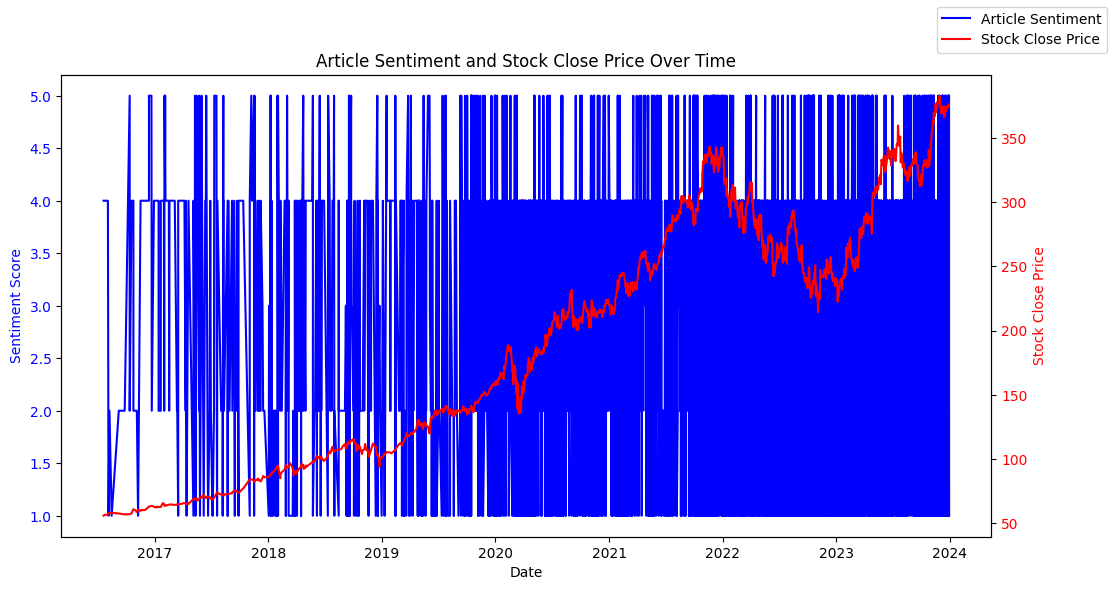

In [16]:
# Ensure consistent column names (strip leading/trailing spaces)
df.columns = df.columns.str.strip()

# Convert the 'date' column to datetime for proper plotting
df['date'] = pd.to_datetime(df['date'])

# Plotting article sentiment and stock close price with a secondary y-axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the article sentiment (1 to 5 scale)
ax1.plot(df['date'], df['article_sentiment'], color='b', label='Article Sentiment')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a secondary y-axis for the stock close price
ax2 = ax1.twinx()
ax2.plot(df['date'], df['Close'], color='r', label='Stock Close Price')
ax2.set_ylabel('Stock Close Price', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set the title and legend
plt.title('Article Sentiment and Stock Close Price Over Time')
fig.legend(loc='upper right')

# Show the plot
plt.show()